# Calculating the Ellipticity-Ellipticity Galaxy-Mass Correlation Functions

### Spencer Everett, SLAC, 7/16/2015

First import all of the necessary files:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
import treecorr
import copy
%matplotlib inline

In [3]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

In [4]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa.fits')

In [5]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

## Using the module directly:

In [6]:
d=[1.9,-1.9,-1.9,1.9]
#d = [1.9,1.8,-1.9,-1.8]
B = pangloss.BackgroundCatalog(sigma_e=0.1,domain=d)
B.lens_by_map(K,S)
galaxies = B.galaxies
print B.galaxy_count

519840


In [7]:
# Need this to remove galaxies not contained in the K/S maps:
#galaxies = [B.galaxies[i] for i in range(B.galaxy_count) if not np.isnan(B.galaxies[i]).any()]
#print np.shape(galaxies)

## xi_+ and xi_x Correlation

In [8]:
gg_int = B.calculate_corr(lensed=False)
gg = B.calculate_corr()

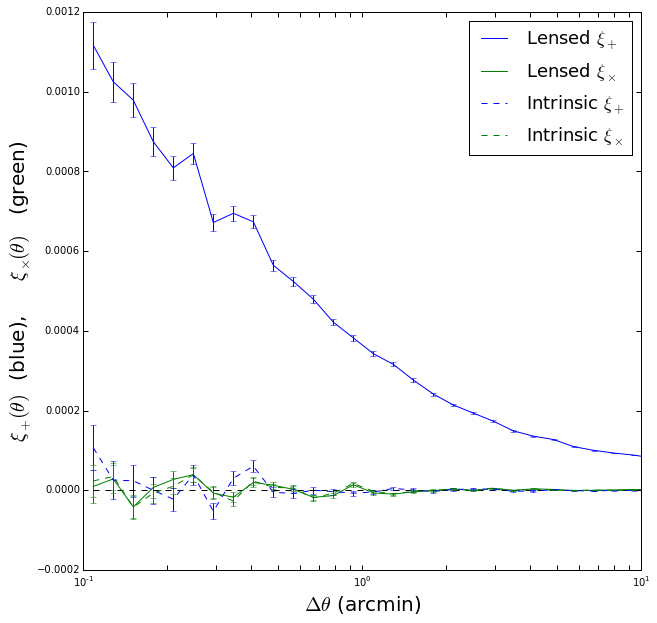

In [9]:
pangloss.plotting.plot_corr(gg,'gg',lensed=True)
pangloss.plotting.plot_corr(gg_int,'gg',lensed=False)

## Correlation with noise

In [10]:
# Domain size
d=[1.9,-1.9,-1.9,1.9]

B1 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)
B1.lens_by_map(K,S)
B2 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)
B2.lens_by_map(K,S)
B3 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d)
B3.lens_by_map(K,S)
#B2 = copy.deepcopy(B1)
#B3 = copy.deepcopy(B1)

B1.add_noise(M=1.0)
galaxies1 = B1.galaxies

B2.add_noise(M=0.9)
galaxies2 = B2.galaxies

B3.add_noise(M=0.8)
galaxies3 = B3.galaxies

KeyboardInterrupt: 

In [ ]:
gg1 = B1.calculate_corr()
gg2 = B2.calculate_corr()
gg3 = B3.calculate_corr()

In [ ]:
# This doesn't quite work yet! Need to add color plotting options for `plot_corr` and option for M plots
pangloss.plotting.plot_corr(gg1)
pangloss.plotting.plot_corr(gg2)
pangloss.plotting.plot_corr(gg3)

In [ ]:
# Pres plot 1
plt.errorbar(np.exp(gg1.logr), gg1.xip, np.sqrt(gg1.varxi), c='r')
plt.errorbar(np.exp(gg2.logr), gg2.xip, np.sqrt(gg2.varxi), c='b')
plt.errorbar(np.exp(gg3.logr), gg3.xip, np.sqrt(gg3.varxi), c='g')
plt.plot([min(np.exp(gg1.logr)),max(np.exp(gg1.logr))],[0,0],c='k',linestyle='dashed')

# Make axis ticks larger
plt.gca().tick_params('both', length=5, width=1, which='major')
plt.gca().tick_params('both', length=5, width=1, which='minor')

# Plot settings
plt.xscale('log')
plt.ylabel(r'$\xi_+(\theta)$',fontsize=20)
plt.xlabel(r'$\Delta\theta$ (arcmin)',fontsize=20)
plt.gcf().set_size_inches(10,10)
plt.gca().set_xlim(np.rad2deg(gg1.min_sep)*60,np.rad2deg(gg1.max_sep)*60)
plt.legend([r'Lensed $\xi_+,\,M=1.0$',r'Lensed $\xi_+,\,M=0.9$',r'Lensed $\xi_+,\,M=0.8$'],fontsize=16)

### Galaxy-Mass:

In [ ]:
config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)
print F.galaxy_count

ng = F.calculate_corr()

In [ ]:
pangloss.plotting.plot_corr(ng,corr_type='ng')

## B-Modes

In [ ]:
galaxies = B1.copy()
rotated_galaxies = B1.copy()

rotated_galaxies['ePhi'] += 45.0

gg = galaxies.calc_corr()
gg45 = rotated_galaxies.calc_corr()

pangloss.plotting.plot_corr(gg)
pangloss.plotting.plot_corr(gg45)